# Benchmarking Results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

### 1. Load, Summarize, Insert

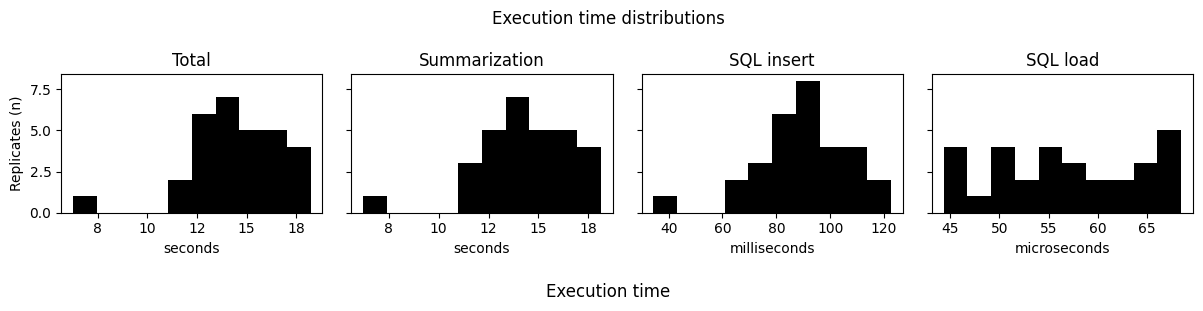

,replicate,num_abstracts,total_replicate_time,total_summarization_time,total_insert_time,total_loading_time,mean_total_time,mean_summarization_time,mean_insert_time,mean_loading_time
0,1,5,91.137909,90.621423,0.516188,0.000299,18.227582,18.124285,0.103238,0.000060
1,2,5,81.190633,80.775728,0.414573,0.000333,16.238127,16.155146,0.082915,0.000067
2,3,5,61.206696,60.843378,0.363094,0.000224,12.241339,12.168676,0.072619,0.000045
3,4,5,81.342521,80.803011,0.539262,0.000247,16.268504,16.160602,0.107852,0.000049
4,5,5,88.175071,87.580209,0.594577,0.000284,17.635014,17.516042,0.118915,0.000057


In [2]:
data = pd.read_csv('../benchmarks/load_summarize_insert/results.csv')

titles = ['Total', 'Summarization', 'SQL insert', 'SQL load']
data_types = ['mean_total_time', 'mean_summarization_time', 'mean_insert_time', 'mean_loading_time']
xlabels = ['seconds', 'seconds', 'milliseconds', 'microseconds']
xaxis_scales = [1, 1, 10**3, 10**6]

fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True, tight_layout=True)

fig.suptitle('Execution time distributions')
fig.supxlabel('Execution time')

axs_num = 0

for title, data_type, xlabel, xaxis_scale in zip(titles, data_types, xlabels, xaxis_scales):

    axs[axs_num].set_title(title)
    axs[axs_num].set_xlabel(xlabel)
    axs[axs_num].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axs[axs_num].hist(
        data[data_type] * xaxis_scale,
        histtype='stepfilled', 
        cumulative=0,
        color='black'
    )

    axs_num += 1

axs[0].set_ylabel('Replicates (n)')

plt.show()

data.head()


### 2. Huggingface Device Map

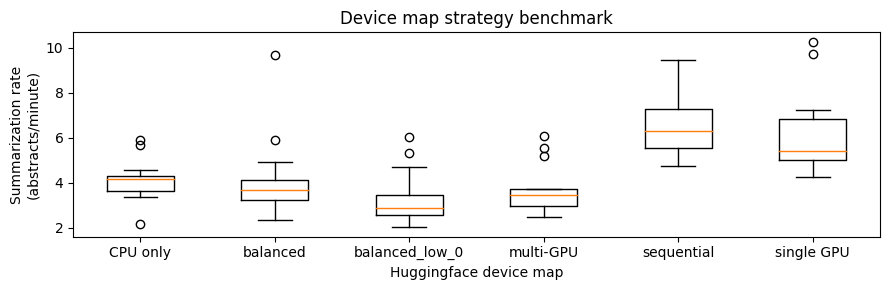

,abstract,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,1,CPU only,27.611567,0.036217,2.173002
1,2,CPU only,16.454564,0.060773,3.646405
2,3,CPU only,13.135237,0.076131,4.567866
3,4,CPU only,14.419200,0.069352,4.161119
4,5,CPU only,14.056253,0.071143,4.268563


In [3]:
data = pd.read_csv('../benchmarks/huggingface_device_map/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

wide_data = data.pivot(index='abstract', columns='device map strategy', values='summarization rate (abstracts/min.)')

fig, axs = plt.subplots(1, 1, figsize=(9, 3), tight_layout=True)

axs.set_title('Device map strategy benchmark')
axs.set_xlabel('Huggingface device map')
axs.set_ylabel('Summarization rate\n(abstracts/minute)')
axs.boxplot(wide_data, labels=wide_data.columns)

plt.show()

data.head()

In [4]:
wide_data.head()

device map strategy,CPU only,balanced,balanced_low_0,multi-GPU,sequential,single GPU
abstract,,,,,,
1,2.173002,3.746729,2.441936,3.278256,4.932982,9.716822
2,3.646405,3.596556,5.340293,3.556333,5.553227,6.763292
3,4.567866,2.720373,2.653123,5.192772,6.278180,7.231493
4,4.161119,3.469443,2.284788,3.740940,6.362110,5.229526
5,4.268563,5.908709,2.023910,3.321397,7.531686,5.574107


### 3. Parallel Summarization

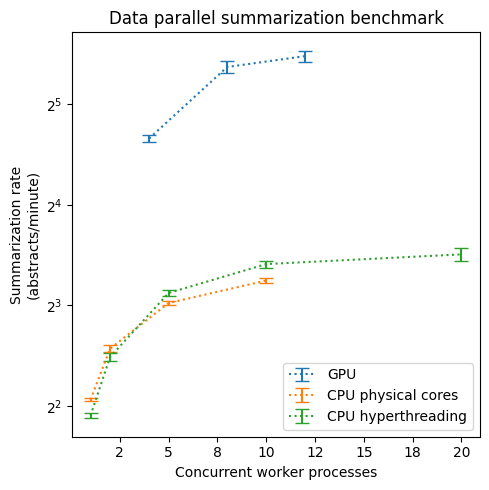

,replicate,abstracts,abstracts per worker,workers,device map strategy,summarization time (sec.),summarization rate (abstracts/sec.),summarization rate (abstracts/min.)
0,0,120,30,4,GPU,280.046850,0.428500,25.709984
1,1,120,30,4,GPU,292.025422,0.410923,24.655388
2,2,120,30,4,GPU,283.045286,0.423960,25.437626
3,3,120,30,4,GPU,277.615275,0.432253,25.935172
4,4,120,30,4,GPU,290.920466,0.412484,24.749032


In [5]:
data = pd.read_csv('../benchmarks/parallel_summarize/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60

device_map_strategies = ['GPU', 'CPU physical cores', 'CPU hyperthreading']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('Data parallel summarization benchmark')
axs.set_xlabel('Concurrent worker processes')
axs.set_ylabel('Summarization rate\n(abstracts/minute)')
axs.set_yscale('log', base=2)
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

for device_map_strategy in device_map_strategies:

    plot_data = data[data['device map strategy'] == device_map_strategy]

    mean = plot_data.groupby(['device map strategy', 'workers']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['device map strategy', 'workers']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['workers'], 
        mean['summarization rate (abstracts/min.)'], 
        yerr=std['summarization rate (abstracts/min.)'],
        capsize=5,
        label=device_map_strategy,
        linestyle='dotted'
    )

plt.legend(loc='best')
plt.show()

data.head()

### 4. Model quantization

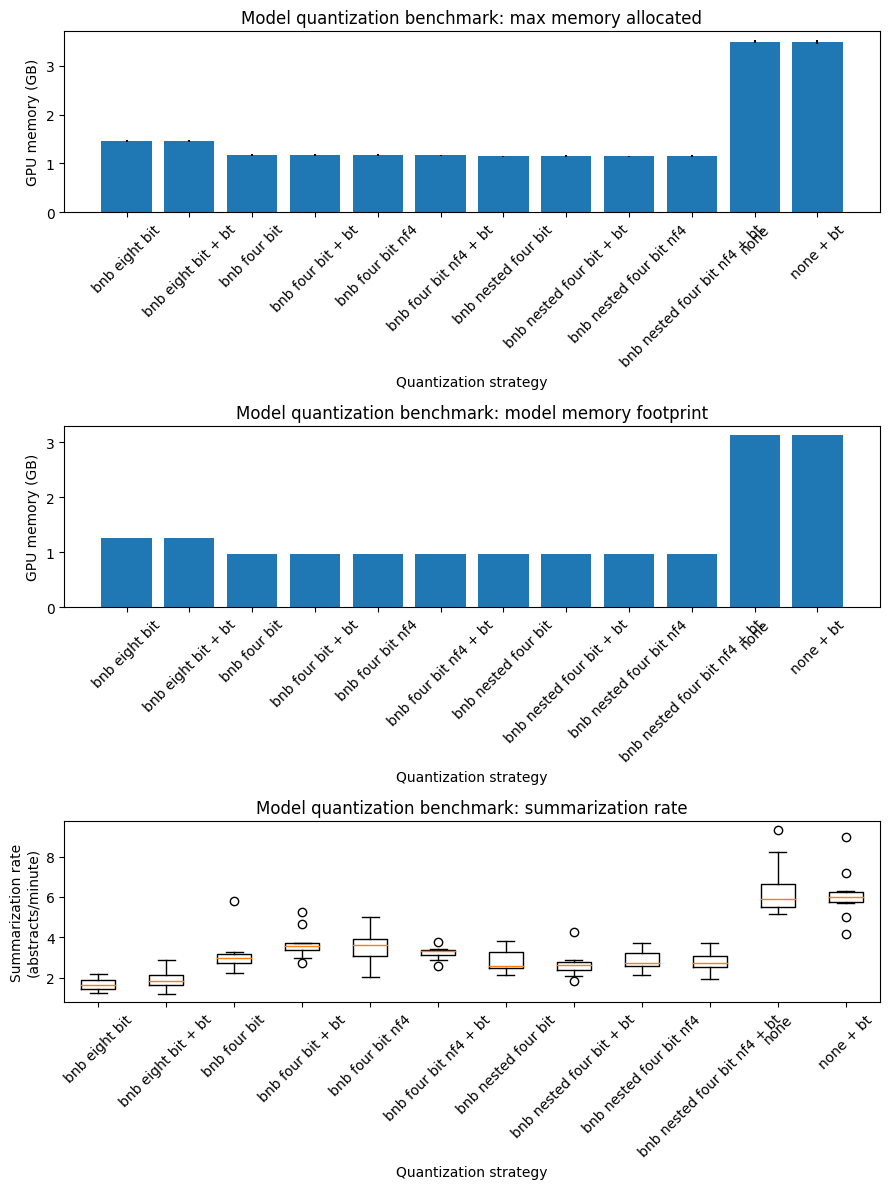

,abstract,optimization strategy,summarization time (sec.),summarization rate (abstracts/sec.),model GPU memory footprint (bytes),max memory allocated (bytes),summarization rate (abstracts/min.),model GPU memory footprint (GB),max memory allocated (GB)
0,1,none,11.344154,0.088151,3132600320,3498729984,5.289068,3.1326,3.498730
1,2,none,6.419127,0.155784,3132600320,3469631488,9.347066,3.1326,3.469631
2,3,none,10.647507,0.093919,3132600320,3497943552,5.635122,3.1326,3.497944
3,4,none,8.976789,0.111398,3132600320,3486147072,6.683905,3.1326,3.486147
4,5,none,9.153605,0.109247,3132600320,3487719936,6.554794,3.1326,3.487720


In [14]:
data = pd.read_csv('../benchmarks/huggingface_GPU_inference/results.csv')
data['summarization rate (abstracts/min.)'] = data['summarization rate (abstracts/sec.)'] * 60
data['model GPU memory footprint (GB)'] = data['model GPU memory footprint (bytes)'] / 10 ** 9
data['max memory allocated (GB)'] = data['max memory allocated (bytes)'] / 10 ** 9

fig, axs = plt.subplots(3, 1, figsize=(9, 12), tight_layout=True)

mean_max_memory_data = data[['optimization strategy', 'max memory allocated (GB)']].groupby('optimization strategy').mean()
std_max_memory_data = data[['optimization strategy', 'max memory allocated (GB)']].groupby('optimization strategy').std()

axs[0].set_title('Model quantization benchmark: max memory allocated')
axs[0].set_xlabel('Quantization strategy')
axs[0].set_ylabel('GPU memory (GB)')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].bar(
    x=mean_max_memory_data.index, 
    height=mean_max_memory_data['max memory allocated (GB)'],
    yerr=std_max_memory_data['max memory allocated (GB)'] * 3
)

mean_memory_footprint_data = data[['optimization strategy', 'model GPU memory footprint (GB)']].groupby('optimization strategy').mean()

axs[1].set_title('Model quantization benchmark: model memory footprint')
axs[1].set_xlabel('Quantization strategy')
axs[1].set_ylabel('GPU memory (GB)')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].bar(x=mean_memory_footprint_data.index, height=mean_memory_footprint_data['model GPU memory footprint (GB)'])

rate_data = data[['abstract', 'optimization strategy', 'summarization rate (abstracts/min.)']]
rate_data = data.pivot(index='abstract', columns='optimization strategy', values='summarization rate (abstracts/min.)')

axs[2].set_title('Model quantization benchmark: summarization rate')
axs[2].set_xlabel('Quantization strategy')
axs[2].set_ylabel('Summarization rate\n(abstracts/minute)')
axs[2].tick_params(axis='x', labelrotation=45)
axs[2].boxplot(rate_data, labels=rate_data.columns)

plt.show()

data.head()

In [11]:
std_max_memory_data.head()

,max memory allocated (GB)
optimization strategy,
bnb eight bit,0.006151
bnb eight bit + bt,0.007651
bnb four bit,0.005303
bnb four bit + bt,0.005297
bnb four bit nf4,0.007867


In [12]:
mean_max_memory_data.head()

,max memory allocated (GB)
optimization strategy,
bnb eight bit,1.455545
bnb eight bit + bt,1.453421
bnb four bit,1.172943
bnb four bit + bt,1.167225
bnb four bit nf4,1.170502


### 5. SQL Insert

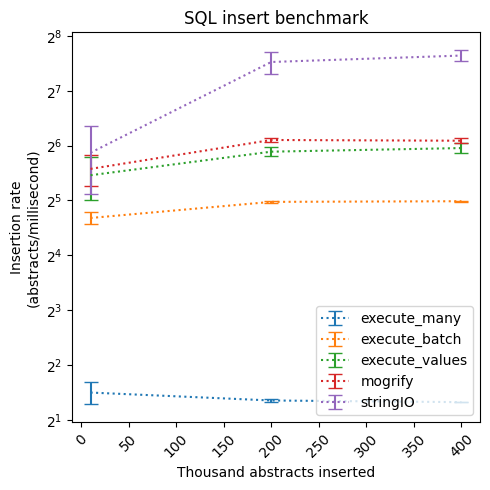

,abstracts,insert time (sec.),insert rate (abstracts/sec.),insert strategy,replicate,insert rate (abstracts/millisecond)
0,10.0,4.011200,2493.019576,execute_many,1,2.493020
1,10.0,4.058270,2464.103887,execute_many,2,2.464104
2,10.0,3.886749,2572.844594,execute_many,3,2.572845
3,10.0,4.013787,2491.413000,execute_many,4,2.491413
4,10.0,3.047673,3281.191670,execute_many,5,3.281192


In [8]:
data = pd.read_csv('../benchmarks/sql_insert/results.csv')
data['insert rate (abstracts/millisecond)'] = data['insert rate (abstracts/sec.)'] / 1000
data['abstracts'] = data['abstracts'] / 1000

insert_strategies = ['execute_many', 'execute_batch', 'execute_values', 'mogrify', 'stringIO']

fig, axs = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

axs.set_title('SQL insert benchmark')
axs.set_xlabel('Thousand abstracts inserted')
axs.set_ylabel('Insertion rate\n(abstracts/millisecond)')
axs.set_yscale('log', base=2)
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axs.tick_params(axis='x', labelrotation=45)

for insert_strategy in insert_strategies:

    plot_data = data[data['insert strategy'] == insert_strategy]

    mean = plot_data.groupby(['insert strategy', 'abstracts']).mean()
    mean.reset_index(inplace=True)
    
    std = plot_data.groupby(['insert strategy', 'abstracts']).std()
    std.reset_index(inplace=True)

    axs.errorbar(
        mean['abstracts'], 
        mean['insert rate (abstracts/millisecond)'], 
        yerr=std['insert rate (abstracts/millisecond)'],
        capsize=5,
        label=insert_strategy,
        linestyle='dotted'
    )

plt.legend(loc='lower right')
plt.show()

data.head()